### Starting story of **SVM**

In [1]:
import os
import math
import pickle
import numpy as np
import pandas as pd
import cv2
from collections import Counter
from pylab import rcParams
import seaborn as sns
from sklearn import svm, datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Enable inline plotting
%matplotlib inline

# Load all files in the '/content/sample_data' directory and print their path
for dirname, _, filenames in os.walk('/content/sample_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/sample_data/README.md
/content/sample_data/anscombe.json
/content/sample_data/mnist_train_small.csv
/content/sample_data/california_housing_train.csv
/content/sample_data/mnist_test.csv
/content/sample_data/california_housing_test.csv


In [2]:
def unpickle(file):
    with open(file, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    return data

In [3]:
def print_items(data):
    for item in data:
        print(item, type(data[item]))

train_data = unpickle('/content/drive/MyDrive/Colab Notebooks/train')
print_items(train_data)

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


In [4]:
def print_labels(data, label_type):
    print(label_type, "labels:", "\n", data[label_type], "\n")

test_data = unpickle('/content/drive/MyDrive/Colab Notebooks/test')
meta_data = unpickle('/content/drive/MyDrive/Colab Notebooks/meta')

print_labels(meta_data, 'fine_label_names')
print_labels(meta_data, 'coarse_label_names')

fine_label_names labels: 
 ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrob

In [5]:
def create_dataframe(data, label_type):
    sub_category = pd.DataFrame(data[label_type], columns=['SubClass'])
    return sub_category

meta_data = unpickle('/content/drive/MyDrive/Colab Notebooks/meta')
sub_category = create_dataframe(meta_data, 'fine_label_names')
print(sub_category)

         SubClass
0           apple
1   aquarium_fish
2            baby
3            bear
4          beaver
..            ...
95          whale
96    willow_tree
97           wolf
98          woman
99           worm

[100 rows x 1 columns]


In [6]:
def reshape_data(data):
    X_train = data['data']
    return X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1)

train_data = unpickle('/content/drive/MyDrive/Colab Notebooks/train')
X_train = reshape_data(train_data)

In [7]:
def reshape_data(data):
    X_test = data['data']
    return X_test.reshape(len(X_test),3,32,32).transpose(0,2,3,1)

test_data = unpickle('/content/drive/MyDrive/Colab Notebooks/test')
X_test = reshape_data(test_data)

In [8]:
def create_parameters():
    winSize = (32,32)
    blockSize = (8,8)
    blockStride = (4,4)
    cellSize = (4,4)
    nbins = 9
    return winSize, blockSize, blockStride, cellSize, nbins

winSize, blockSize, blockStride, cellSize, nbins = create_parameters()

df = []

In [9]:

def compute_hog(X_train):
    df = []
    for i in range(5):
        image = cv2.cvtColor(X_train[i],cv2.COLOR_BGR2GRAY)
        hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
        df.append(hog.compute(image))
    return df

DF = pd.DataFrame(compute_hog(X_train))
DF

,0,1,2,3,4,5,6,7,8,9,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,0.032799,0.015301,0.045787,0.000000,0.069334,0.000000,0.000000,0.00000,0.032799,0.067754,...,0.098908,0.316263,0.316263,0.248816,0.060455,0.195416,0.000000,0.025893,0.150303,0.213901
1,0.006916,0.000000,0.000000,0.000000,0.241620,0.000000,0.000000,0.00000,0.006916,0.016505,...,0.000000,0.055166,0.000000,0.000000,0.000000,0.699561,0.000000,0.000000,0.000000,0.055166
2,0.327324,0.175260,0.089584,0.062461,0.073516,0.000000,0.000000,0.00000,0.047610,0.327324,...,0.248223,0.292329,0.292329,0.197667,0.280417,0.292329,0.000000,0.000000,0.000000,0.034408
3,0.097244,0.235721,0.044991,0.010438,0.005530,0.000000,0.000000,0.00000,0.008888,0.155014,...,0.058511,0.069262,0.084507,0.002409,0.000000,0.305709,0.124439,0.305709,0.305709,0.095173
4,0.227998,0.040255,0.278890,0.130381,0.014747,0.007472,0.119501,0.27889,0.096910,0.072541,...,0.261557,0.148019,0.049396,0.163622,0.247557,0.261557,0.261557,0.198627,0.261557,0.261557


In [10]:
def compute_hog(X_test):
    df = []
    for i in range(10000):
        image = cv2.cvtColor(X_test[i],cv2.COLOR_BGR2GRAY)
        hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
        df.append(hog.compute(image))
    return df

DFTest = pd.DataFrame(compute_hog(X_test))
DFTest


,0,1,2,3,4,5,6,7,8,9,...,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763
0,0.005963,0.014246,0.155839,0.322189,0.322189,0.140535,0.001042,0.045787,0.008237,0.012231,...,0.231120,0.161629,0.000000,0.000568,0.002284,0.152461,0.077151,0.199670,0.294496,0.294496
1,0.156582,0.106717,0.129119,0.024887,0.026738,0.000395,0.109805,0.221431,0.243349,0.184052,...,0.008029,0.068975,0.014179,0.049522,0.036160,0.296550,0.296550,0.295574,0.220899,0.090293
2,0.157612,0.180906,0.202116,0.303207,0.135402,0.062558,0.014834,0.000000,0.140125,0.130571,...,0.111859,0.118122,0.205734,0.106534,0.035008,0.269064,0.233342,0.269064,0.174488,0.131494
3,0.043514,0.059188,0.147992,0.197210,0.232059,0.210929,0.050399,0.182179,0.016104,0.024534,...,0.312229,0.312229,0.232256,0.174586,0.093909,0.175129,0.020560,0.004958,0.005922,0.312229
4,0.163315,0.181456,0.115493,0.024030,0.015073,0.058403,0.060261,0.124847,0.188402,0.311937,...,0.000000,0.052938,0.166641,0.309478,0.309478,0.309478,0.000000,0.000000,0.000000,0.031860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.173740,0.122762,0.169510,0.206014,0.084006,0.005670,0.007117,0.070334,0.100407,0.214993,...,0.119464,0.257086,0.112364,0.147237,0.151331,0.257086,0.129020,0.257086,0.087646,0.186102
9996,0.055689,0.059882,0.053796,0.186244,0.248748,0.207453,0.073787,0.039826,0.052099,0.035359,...,0.085541,0.180778,0.047281,0.041746,0.009357,0.174976,0.262277,0.262277,0.175338,0.152917
9997,0.003751,0.000589,0.010963,0.170294,0.380156,0.078815,0.019148,0.017547,0.005784,0.003980,...,0.228988,0.146029,0.041986,0.002324,0.011588,0.223576,0.046381,0.032553,0.315884,0.315884
9998,0.077604,0.278118,0.278118,0.056759,0.140844,0.011411,0.016400,0.024156,0.066294,0.120425,...,0.131470,0.273277,0.219399,0.103344,0.226747,0.126607,0.000492,0.001228,0.007669,0.160087


In [11]:
train_data = unpickle('/content/drive/MyDrive/Colab Notebooks/train')
metaData = unpickle('/content/drive/MyDrive/Colab Notebooks/meta')
subCategory = pd.DataFrame(metaData['fine_label_names'], columns=['SubClass'])

def create_label(subCategory, trainData, label_type):
    y_train = []
    for i in range(len(trainData)):
        y_train.append(subCategory.iloc[trainData[label_type][i]][0].capitalize())
    return y_train

y_train = create_label(subCategory, train_data, 'fine_labels')

In [12]:
testData = unpickle('/content/drive/MyDrive/Colab Notebooks/test')
y_test = [subCategory.iloc[testData['fine_labels'][i]][0].capitalize() 
for i in range(testData['data'].shape[0])]




In [13]:
def train_svm(X, y):
    linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X, y)
    rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X, y)
    poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X, y)
    sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X, y)
    return linear, rbf, poly, sig

linear, rbf, poly, sig = train_svm(DF, y_train)

In [14]:
linear_pred = linear.predict(DFTest)
poly_pred = poly.predict(DFTest)
rbf_pred = rbf.predict(DFTest)
sig_pred = sig.predict(DFTest)

In [15]:
accuracy_lin = linear.score(DFTest, y_test)
accuracy_poly = poly.score(DFTest, y_test)
accuracy_rbf = rbf.score(DFTest, y_test)
accuracy_sig = sig.score(DFTest, y_test)

print("Accuracy Linear Kernel:", accuracy_lin)
print("Accuracy Polynomial Kernel:", accuracy_poly)
print("Accuracy Radial Basis Kernel:", accuracy_rbf)
print("Accuracy Sigmoid Kernel:", accuracy_sig)

Accuracy Linear Kernel: 0.0138
Accuracy Polynomial Kernel: 0.0137
Accuracy Radial Basis Kernel: 0.0138
Accuracy Sigmoid Kernel: 0.0138


In [16]:
cm_lin = confusion_matrix(y_test, linear_pred)
cm_poly = confusion_matrix(y_test, poly_pred)
cm_rbf = confusion_matrix(y_test, rbf_pred)
cm_sig = confusion_matrix(y_test, sig_pred)

In [17]:
x = np.array(y_test)
cm_dfLin = pd.DataFrame(cm_lin,index = np.unique(x),columns = np.unique(x))
cm_dfPoly = pd.DataFrame(cm_poly,index = np.unique(x),columns = np.unique(x))
cm_dfrbf = pd.DataFrame(cm_rbf,index = np.unique(x),columns = np.unique(x))
cm_dfsig = pd.DataFrame(cm_sig,index = np.unique(x),columns = np.unique(x))

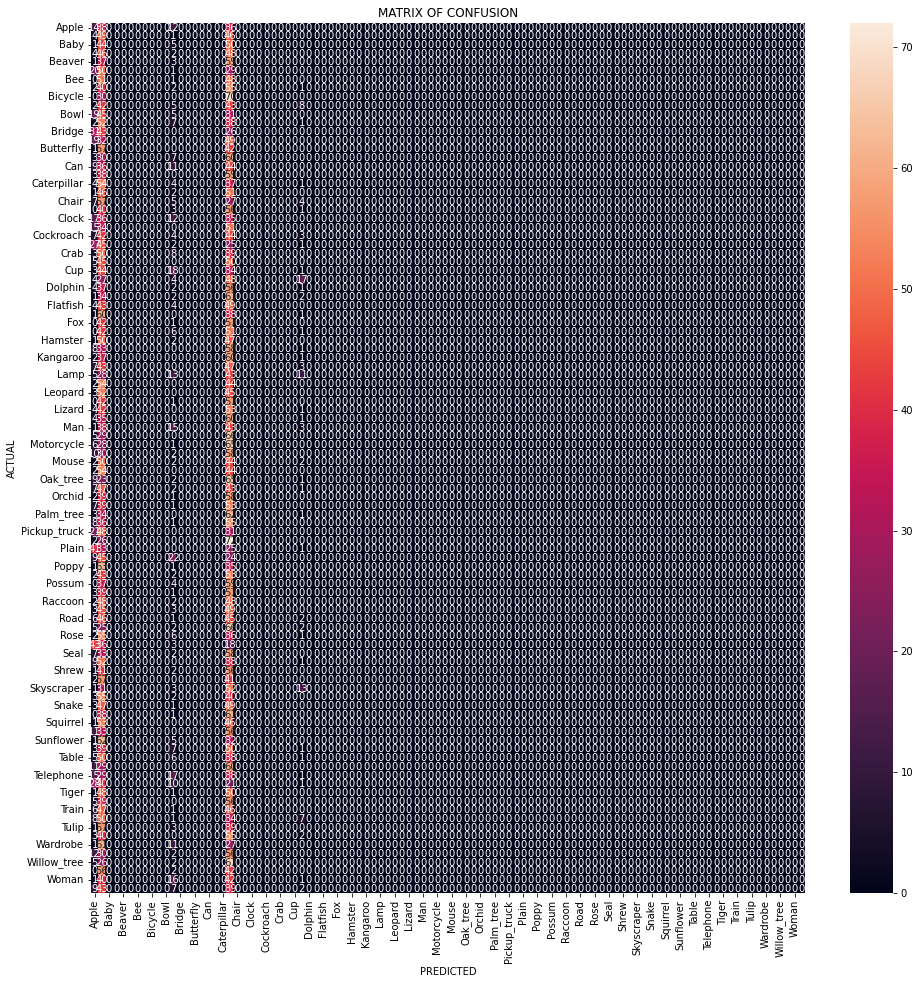

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure(figsize=(16,16))
sns.heatmap(cm_dfLin, annot=True)
plt.title('MATRIX OF CONFUSION')
plt.ylabel('ACTUAL')
plt.xlabel('PREDICTED')
plt.show()
plt.savefig('LinearKernelCM.png')

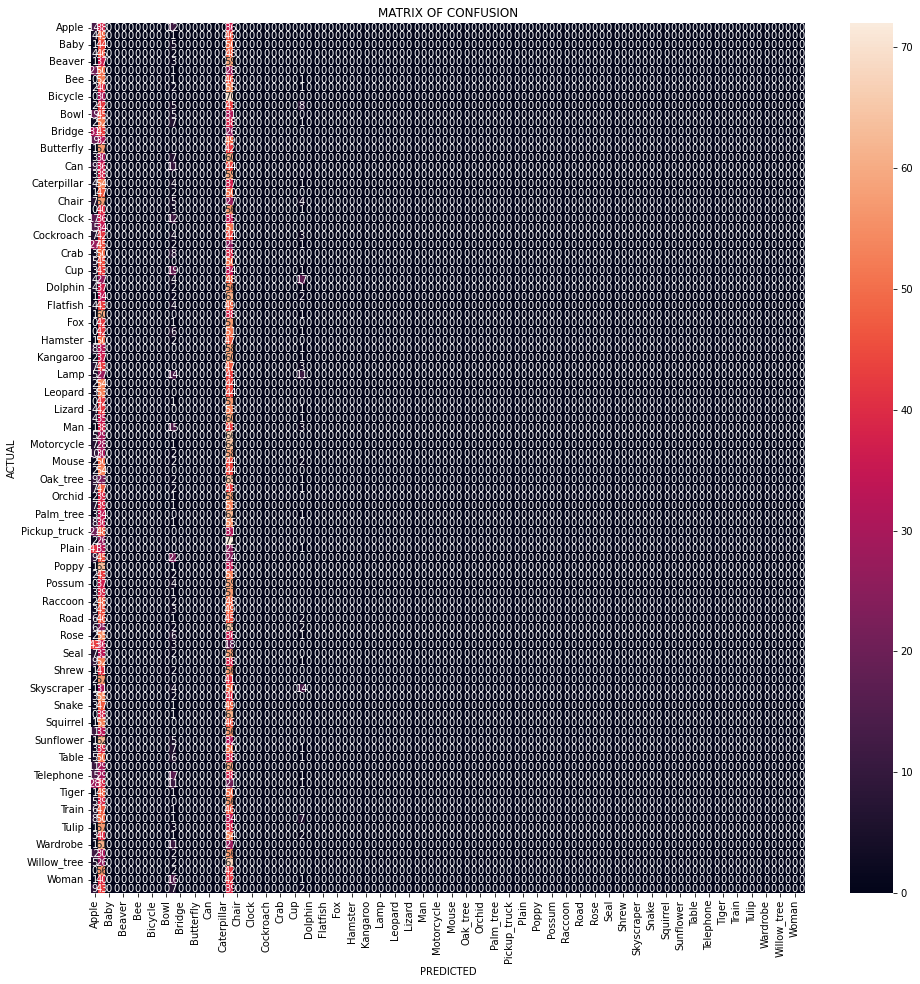

<Figure size 432x288 with 0 Axes>

In [19]:
plt.figure(figsize=(16,16))
sns.heatmap(cm_dfPoly, annot=True)
plt.title('MATRIX OF CONFUSION')
plt.ylabel('ACTUAL')
plt.xlabel('PREDICTED')
plt.show()
plt.savefig('PolynomialKernelCM.png')

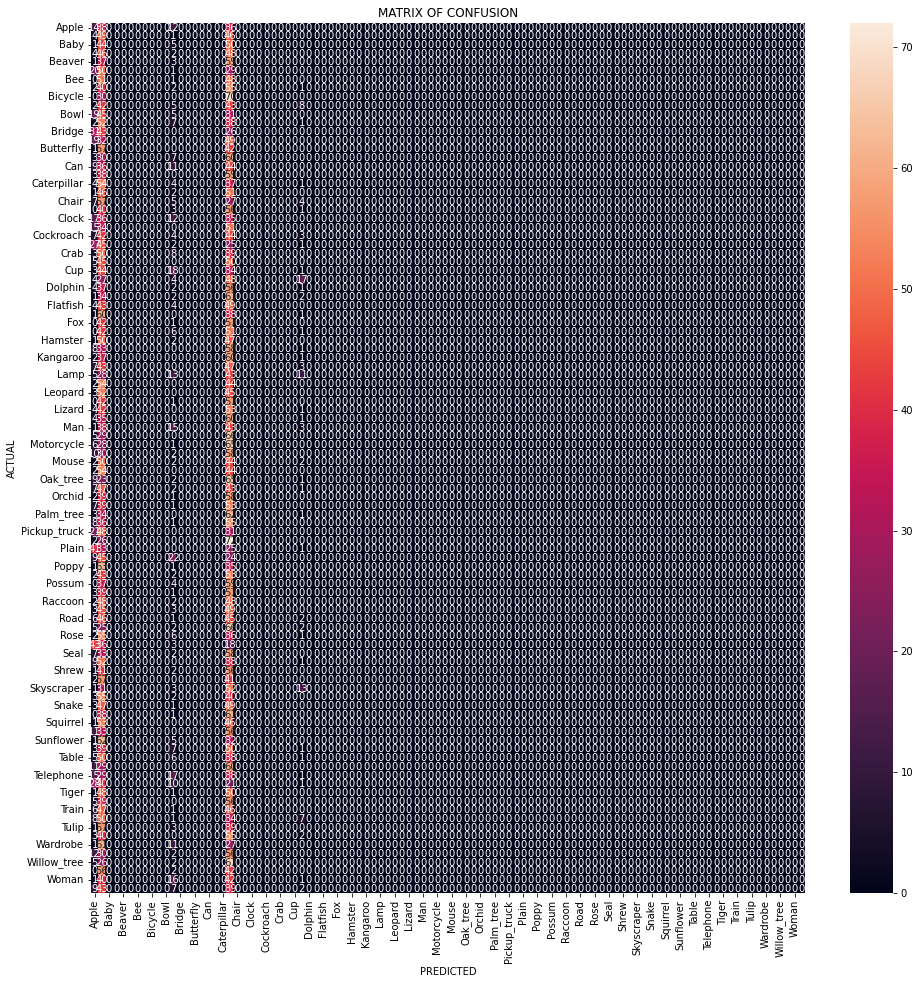

<Figure size 432x288 with 0 Axes>

In [20]:
plt.figure(figsize=(16,16))
sns.heatmap(cm_dfrbf, annot=True)
plt.title('MATRIX OF CONFUSION')
plt.ylabel('ACTUAL')
plt.xlabel('PREDICTED')
plt.show()
plt.savefig('RadialBasisKernelCM.png')

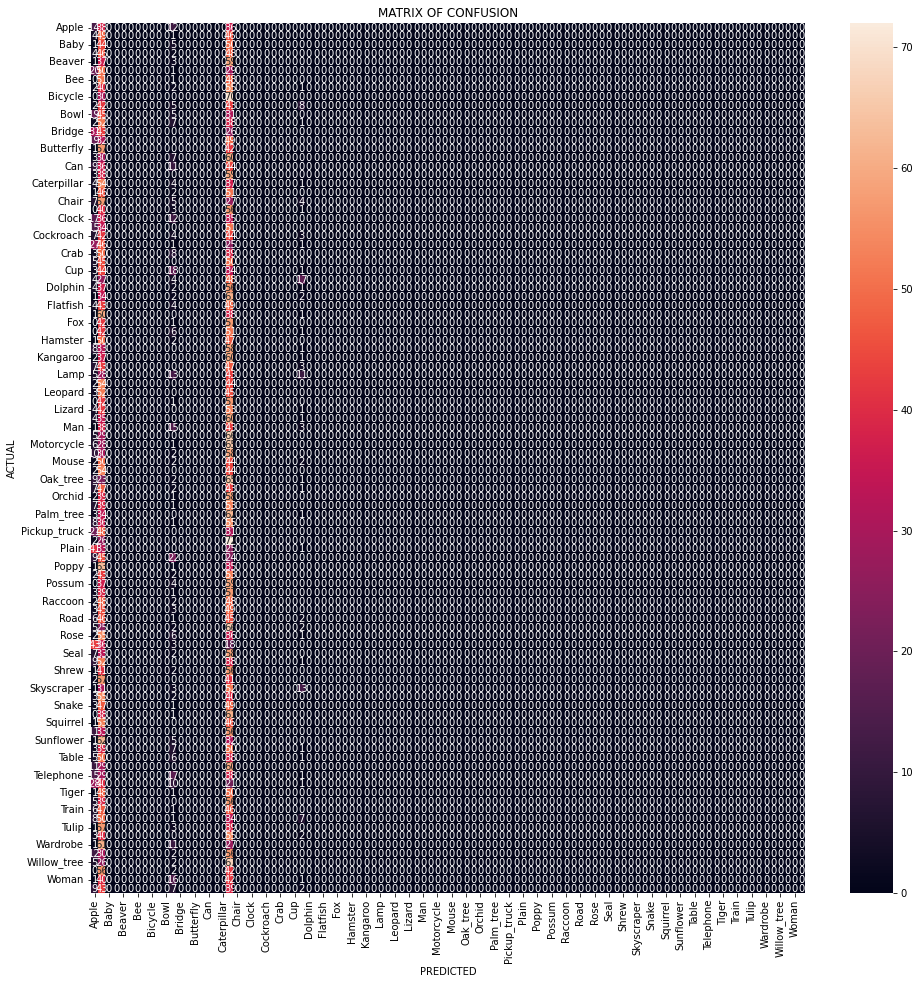

<Figure size 432x288 with 0 Axes>

In [21]:
plt.figure(figsize=(16,16))
sns.heatmap(cm_dfsig, annot=True)
plt.title('MATRIX OF CONFUSION')
plt.ylabel('ACTUAL')
plt.xlabel('PREDICTED')
plt.show()
plt.savefig('SigmoidKernelCM.png')